<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/Particlefiltertracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INF6804 Vision par ordinateur

Polytechnique Montréal

Exemple de suivi avec par filtres de particules.

In [1]:
import cv2  
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random as ran

Fonction pour calculer la similarité entre 2 histogrammes.

In [2]:
def CompareParticles(hist1, hist2):
    return 1 - cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

Fonction qui calcule l'histogramme d'une image à l'intérieur d'un rectangle englobant.

In [3]:
def CalcHisto(image, bbox):
    roi = (bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3])
    mask = np.zeros((image.shape[0],image.shape[1]), np.uint8)
    cv2.rectangle(mask,(roi[0],roi[1]),(roi[2],roi[3]),255,-1,8,0);
    return cv2.calcHist([image1],[0],mask,[64],[0,256])

Fonction pour générer des particles selon la méthode d'échantillonnage préférentiel (importance sampling).

In [4]:
def GenererParticules(Particules, nbparticules, mvt = 20 , poids = None):
    if len(Particules)==1:
        #Pour générer les particules initiales. Pas de poids disponible
        #Déplacement aléatoire de ROI initial de [-mvt, mvt]
        NouvParticules = Particules
        for i in range(1,nbparticules):
            part = [(Particules[0][0]+ran.randint(-mvt,mvt), Particules[0][1]+ran.randint(-mvt,mvt), Particules[0][2], Particules[0][3])]
            NouvParticules = NouvParticules + part
    else:
        # Échantillonage préférentiel avec la fonction ran.choices()
        temp = ran.choices(Particules,poids)[0]
        # Mise à jour de leur état en ajoutant une translation en X et Y.
        part = [(temp[0]+ran.randint(-mvt,mvt), temp[1]+ran.randint(-mvt,mvt), temp[2], temp[3])]
        NouvParticules = part
        for i in range(1,nbparticules):
            temp = ran.choices(Particules,poids)[0]
            part = [(temp[0]+ran.randint(-mvt,mvt), temp[1]+ran.randint(-mvt,mvt), temp[2], temp[3])]
            NouvParticules = NouvParticules + part
    return NouvParticules

Lecture de deux images tests et affichage.

In [5]:
image_name = 'in000216.jpg'
if not os.path.exists(image_name):
  !gdown https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/in000216.jpg
  !gdown https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/in000219.jpg
  !gdown https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/in000222.jpg
  !gdown https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/in000225.jpg

Downloading...
From: https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/in000216.jpg
To: /content/in000216.jpg
100% 178k/178k [00:00<00:00, 2.78MB/s]
Downloading...
From: https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/in000219.jpg
To: /content/in000219.jpg
100% 178k/178k [00:00<00:00, 2.77MB/s]
Downloading...
From: https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/in000222.jpg
To: /content/in000222.jpg
100% 178k/178k [00:00<00:00, 2.79MB/s]
Downloading...
From: https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/in000225.jpg
To: /content/in000225.jpg
100% 177k/177k [00:00<00:00, 2.76MB/s]


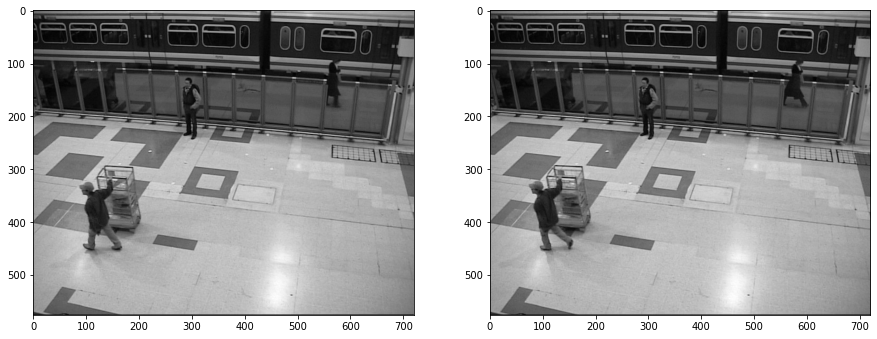

In [6]:
image1 = cv2.imread('in000216.jpg',cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('in000219.jpg',cv2.IMREAD_GRAYSCALE) 
f, axarr = plt.subplots(1, 2, figsize=(15,15))
axarr[0].imshow(image1,cmap = plt.get_cmap('gray'))
axarr[1].imshow(image2,cmap = plt.get_cmap('gray'))
plt.show()

Définition du rectangle englobant (bbox) de la région d'intérêt (ROI).

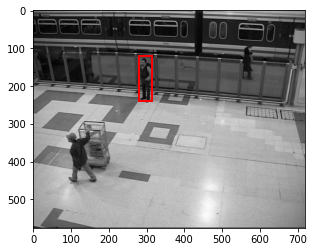

In [7]:
# Pour suivre une des trois personnes
bbox = (279, 120, 36, 120)
#bbox = (83, 300, 70, 160)
#bbox = (547, 90, 45, 100)
fig,ax = plt.subplots(1)
ax.imshow(image1,cmap = plt.get_cmap('gray'))
rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

Définition des paramètres et calcule de l'histogramme de l'objet à suivre. Génération des particules initiales et affichage.

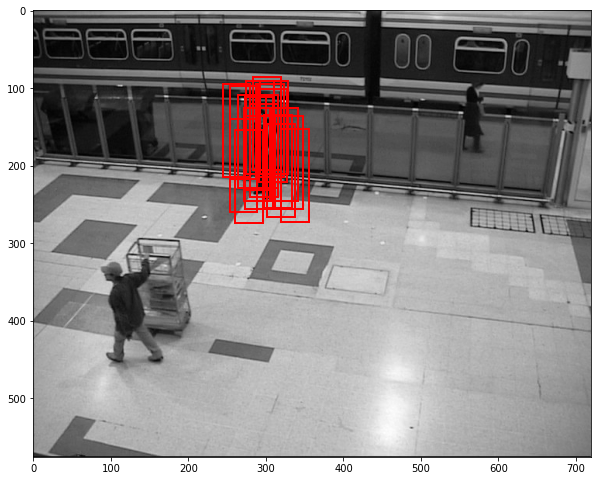

In [8]:
nbpart = 20  #Nombre de particules
mouvement = 40  #Déplacement max en X et Y
modele = CalcHisto(image1, bbox) 
particules= GenererParticules([bbox],nbpart, mouvement)
fig,ax = plt.subplots(1,figsize=(10,10))
ax.imshow(image1,cmap = plt.get_cmap('gray'))
for p in particules:
    rect = patches.Rectangle((p[0],p[1]),p[2],p[3],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

Suivi: Évaluation des particules + choix de la meilleur pour la nouvelle position de l'objet.

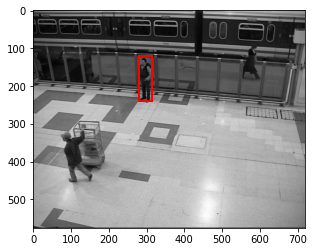

In [9]:
poids =[]
for p in particules:
    candidat = CalcHisto(image2, p)
    dist = CompareParticles(modele, candidat) 
    poids.append(dist)
    
fig,ax = plt.subplots(1)
ax.imshow(image2,cmap = plt.get_cmap('gray'))
p = particules[poids.index(max(poids))]
rect = patches.Rectangle((p[0],p[1]),p[2],p[3],linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

Suivi sur deux autres trames...

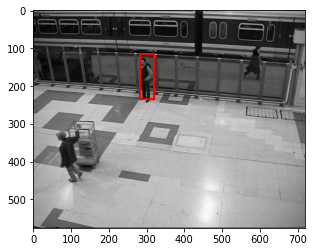

In [10]:
image3 = cv2.imread('in000222.jpg',cv2.IMREAD_GRAYSCALE) 
particules = GenererParticules(particules,nbpart, mouvement, poids)
poids =[]
for p in particules:
    candidat = CalcHisto(image3, p)
    dist = CompareParticles(modele, candidat)
    poids.append(dist)
    
fig,ax = plt.subplots(1)
ax.imshow(image3,cmap = plt.get_cmap('gray'))
p = particules[poids.index(max(poids))]
rect = patches.Rectangle((p[0],p[1]),p[2],p[3],linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

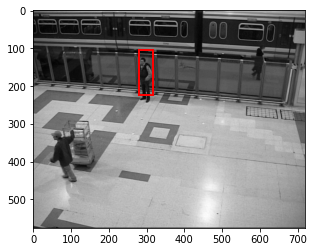

In [11]:
image4 = cv2.imread('in000225.jpg',cv2.IMREAD_GRAYSCALE) 
particules = GenererParticules(particules, nbpart, mouvement, poids)
poids =[]
for p in particules:
    candidat = CalcHisto(image4, p)
    dist = CompareParticles(modele, candidat)
    poids.append(dist)
    
fig,ax = plt.subplots(1)
ax.imshow(image4,cmap = plt.get_cmap('gray'))
p = particules[poids.index(max(poids))]
rect = patches.Rectangle((p[0],p[1]),p[2],p[3],linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()